# Dataset creation

This notebook gives a schema and the steps to get the ground truth data for our private dataset and later create a dataset that can be loaded for training. To avoid a large size dataset, we create patches from each of the original images with a resolution of 300x300.

## Initialization

Import relevant libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from patchify import patchify
from PIL import Image
import json
import cv2



# Grounding DINO
from groundingdino.util.inference import load_image
from groundingdino.util import box_ops



Set up the main directory and the data directory.

In [4]:
# Set working directory as the main directory
os.chdir("/home/ubuntu/")
# Data directory
data_dir = "/home/ubuntu/data/"

Use CUDA.

In [5]:
# Use CUDA if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Set this bool to true if it is the first time that data is generated or if you want to start over and not recover previous dataset generation.

In [68]:
start_over = False

If we start over: initialize the arrays that will contain the information. There will be one array for the image source directories, one for the grounding boxes and one for the masks paths.
If we do not start over: load the last generated .json file with all the information.

In [69]:
if start_over:
    img_source_list = []
    boxes_list = []
    masks_list = []
else:
    with open(data_dir + "/metadata.json", 'r') as file:
        data = [json.loads(line) for line in file]

    df = pd.concat([pd.json_normalize(entry) for entry in data], ignore_index=True)

    img_source_list = list(df['img'])
    boxes_list = list(df['boxes'])
    masks_list = list(df['masks'])

In [70]:
print(len(img_source_list), len(boxes_list), len(masks_list))

48 48 48


Load the Grounding DINO model.

In [8]:
from utils.setup_dino import load_model_hf

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/home/ubuntu/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/ubuntu/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


## Ground-truth creation pipeline

These are the steps to follow to get the maximum number of ground-truth masks for the private dataset.

### 1. Image loading

First we load one of the images of our dataset.

In [9]:
# Set dev folder
dev = 39
# Set rec folder
rec = 0
# Set data directory
fold_img_path = os.path.join("images", "dev" + str(dev), "rec" + str(rec))
mask_img_path = os.path.join("masks", "dev" + str(dev), "rec" + str(rec))

# Get all elements in the directory (images)
imgs = os.listdir(os.path.join(data_dir, "private", fold_img_path))

Load the image with `groundingdino` function: `load_image`.

/home/ubuntu/data/private/images/dev39/rec0/1593699216.png
1593699216


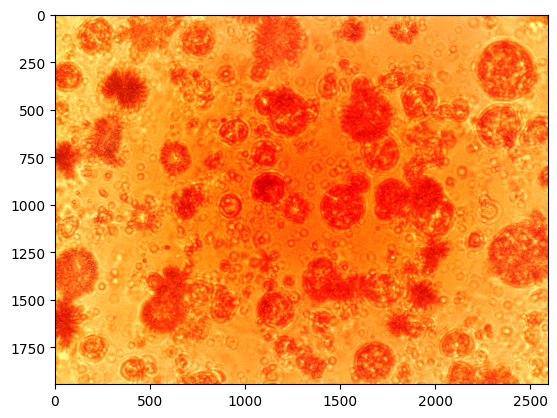

In [74]:
# Set element to get from the list of images
i = 2
# Get the image path
image_path = os.path.join(data_dir, "private", fold_img_path, imgs[i])
print(image_path)
image_source, image = load_image(image_path)
# Image name
img_name = os.path.splitext(imgs[i])[0]
print(img_name)

# Plot image
plt.imshow(image_source, cmap='gray')  

### 2. Image preprocessing

Second we use some preprocessing techniques to get better results with Grounding DINO and SAM. We proceed in two different ways depending on the type of image:
* Orange image: Gamma correction (fine-tune gamma according to each image).
* Grayscale image: Pseudocolor and gamma correction (fine-tune gamma according to each image).

Use the functions given in `utils/image_preprocessing.py` script.

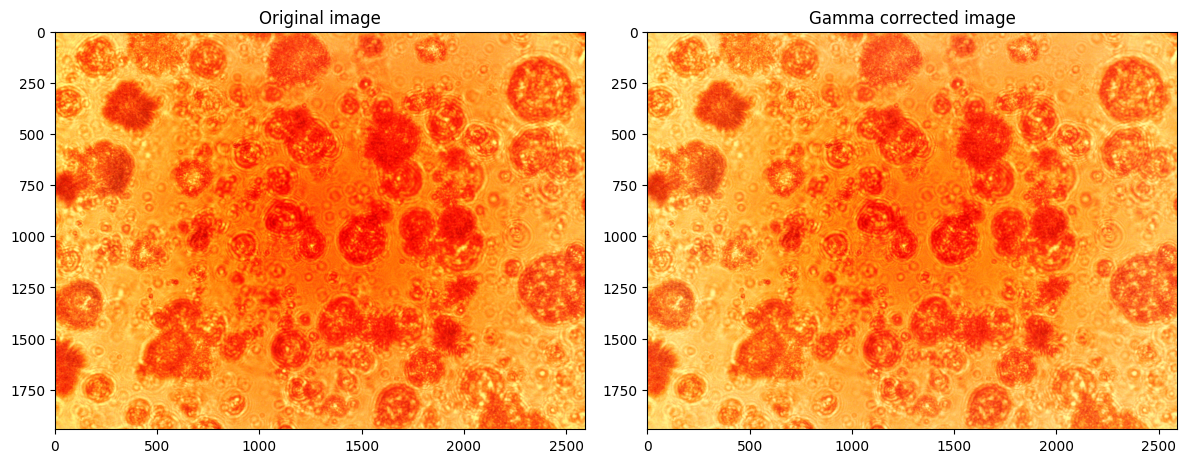

In [11]:
from utils.image_preprocessing import gamma_correction
# Set the value of gamma
gamma = 0.8

# Get corrected image
image_corrected, image_source_corrected = gamma_correction(image, image_source, gamma)

# Plot the corrected image
# Image.fromarray(image_source_corrected)

# Adjust the width and height as needed
plt.figure(figsize=(12, 6))  
# Display the first image
plt.subplot(1, 2, 1)
plt.imshow(image_source, cmap='gray') 
plt.title('Original image')
# Display the second image
plt.subplot(1, 2, 2)
plt.imshow(image_source_corrected, cmap='gray') 
plt.title('Gamma corrected image')
# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

### DINO inference

Run `detect` function from `utils/inference_dino.py` script. Here we get the boxes and we plot the image. Fine-tune the `box_threshold` to get more or less boxes according to the image and set different values for `gamma` in the preprocessing.

/home/ubuntu/venv/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Filtered number of boxes was 76 , after Big Box Overlap Filtering is 54
Filtered number of boxes was 78 , after Big Box Overlap Filtering is 54
Filtered number of boxes was 83 , after Big Box Overlap Filtering is 54
Filtered number of boxes was 87 , after Big Box Overlap Filtering is 54
Filtered number of boxes was 86 , after Big Box Overlap Filtering is 57
Filtered number of boxes was 92 , after Big Box Overlap Filtering is 59
Filtered number of boxes was 99 , after Big Box Overlap Filtering is 64
Filtered number of boxes was 102 , after Big Box Overlap Filtering is 64
Filtered number of boxes was 104 , after Big Box Overlap Filtering is 65


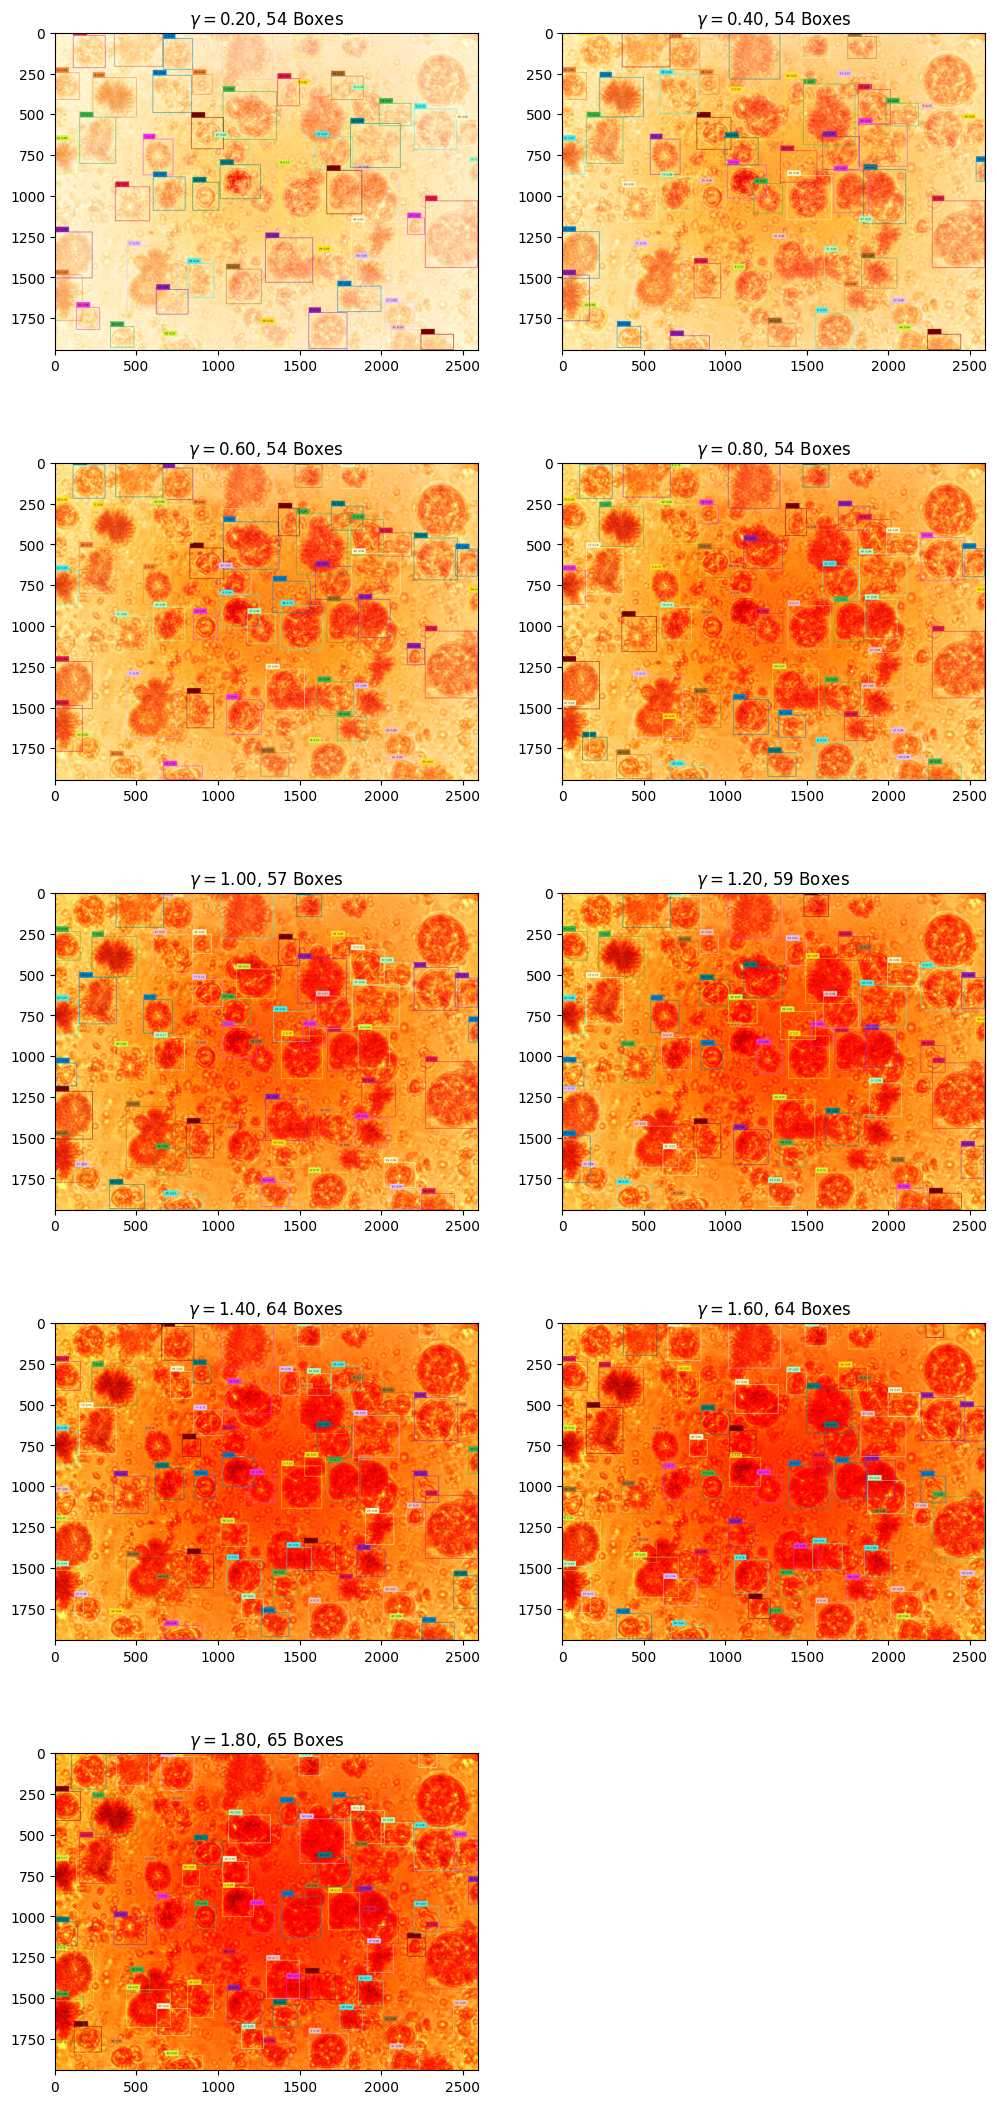

In [75]:
from utils.inference_dino import detect

# Fine-tune text prompt and box threshold
text_prompt = "dark rounds"
box_threshold = 0.02

# Choose values for Gamma
gammas = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8]

# Find and plot all detected boxes

# Adjust the width and height as needed
plt.figure(figsize=(12, 6*len(gammas)//2))  
# Get number of rows
r = len(gammas)//2 + len(gammas)%2
for i, g in enumerate(gammas):
    # Do gamma correction
    image_corrected, image_source_corrected = gamma_correction(image, image_source, g)
    # Parameters bn without contrast
    annotated_frame, detected_boxes = detect(image_corrected, image_source_corrected, text_prompt=text_prompt, model=groundingdino_model,
                                            box_threshold = box_threshold, text_threshold = 0.2, stride_distance = 0.02,
                                            NMS = False, threshold_nms=0.5)
    # Print the subplot
    plt.subplot(r, 2, i+1)
    plt.imshow(annotated_frame, cmap='gray') 
    plt.title(r'$\gamma = {:.2f}$, {} Boxes'.format(g, int(len(detected_boxes)))) 

plt.show()


Choose the best case and plot it to see all the boxes. Every box contains an ID on the top left of text. Identify the ones that need to be eliminated.

Filtered number of boxes was 86 , after Big Box Overlap Filtering is 57


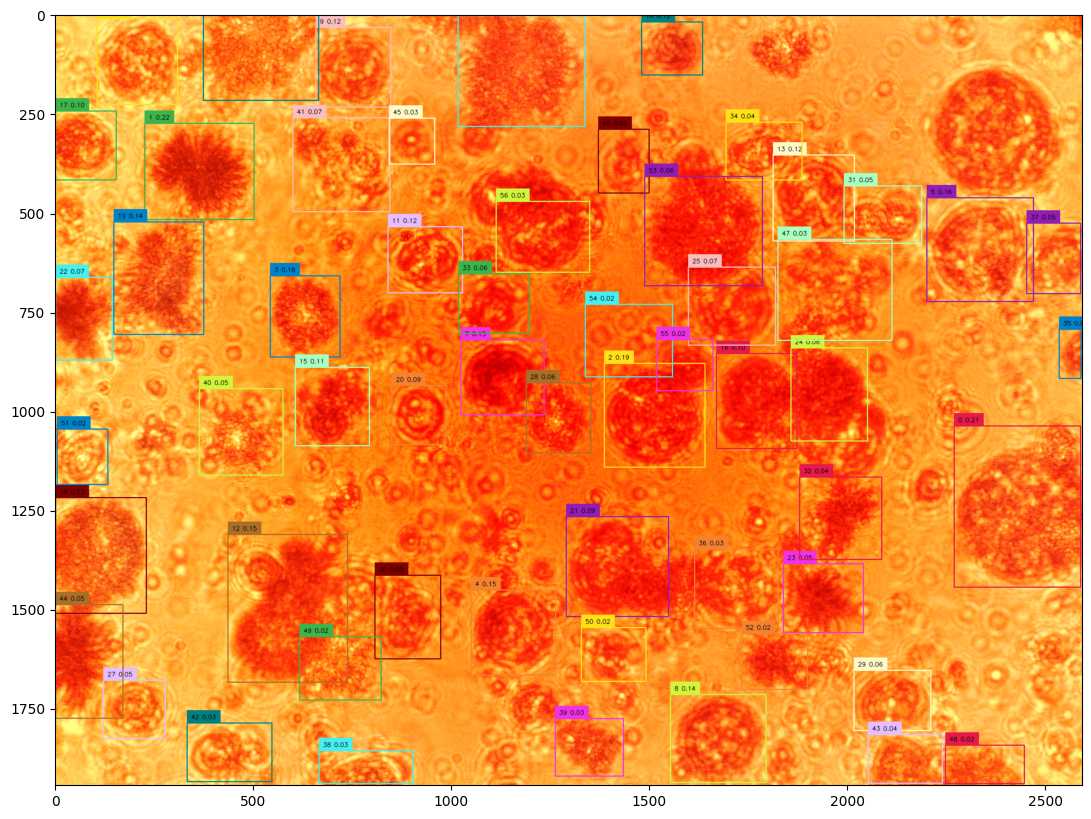

In [76]:
# Define final gamma
final_gamma = 1

# Do gamma correction
image_corrected, image_source_corrected = gamma_correction(image, image_source, final_gamma)
    
# Parameters bn without contrast
annotated_frame, detected_boxes = detect(image_corrected, image_source_corrected, text_prompt=text_prompt, model=groundingdino_model,
                                        box_threshold = box_threshold, text_threshold = 0.2, stride_distance = 0.02,
                                        NMS = False, threshold_nms=0.5)

# Plot the results with the boxes
plt.figure(figsize=(20,10))
plt.imshow(annotated_frame, cmap='gray')  

Write in `id_to_eliminate` list all boxes to eliminate and filter to get the definitive boxes.

In [77]:
id_to_eliminate = [45]

# Get indices to keep
indices_to_keep = torch.tensor(list(set(range(detected_boxes.shape[0])) - set(id_to_eliminate)))
# Use torch.index_select to eliminate rows
detected_boxes = torch.index_select(detected_boxes, 0, indices_to_keep)

### 4. Box list obtention

Here we get a numpy array of shape [num_boxes, coordinates] containing all boxes in a xyxy (ltrb) format

In [78]:
# Get image size
H, W, _ = image_source.shape

# Get final boxes
final_boxes = np.round((box_ops.box_cxcywh_to_xyxy(detected_boxes) * torch.Tensor([W, H, W, H])).numpy())

If necessary, add a box manually.

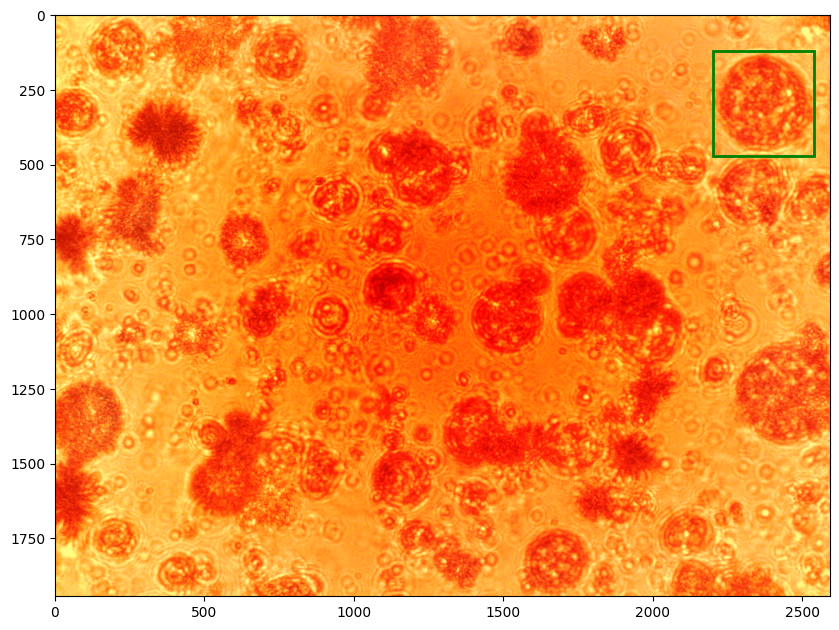

In [80]:
from utils.inference_sam import show_boxes_on_image
boxes_to_add = np.array([[2200, 120, 2540, 470]])
show_boxes_on_image(image_source, boxes_to_add)

In [81]:
# Here we add finally the boxes
final_boxes = np.append(final_boxes, boxes_to_add, axis = 0)
detected_boxes = box_ops.box_xyxy_to_cxcywh(torch.Tensor(final_boxes) / np.array([W, H, W, H]))
print(final_boxes.shape)
print(detected_boxes.shape)

(57, 4)
torch.Size([57, 4])


### 5. SAM inference with final boxes

Load SAM.

In [17]:
from transformers import SamModel, SamProcessor

# Use large encoder here
model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

Run `sam_inference_from_dino` function from `utils/inference_sam.py` script. Here we get all the masks (every mask is a numpy array) and save all of them in one numpy array.

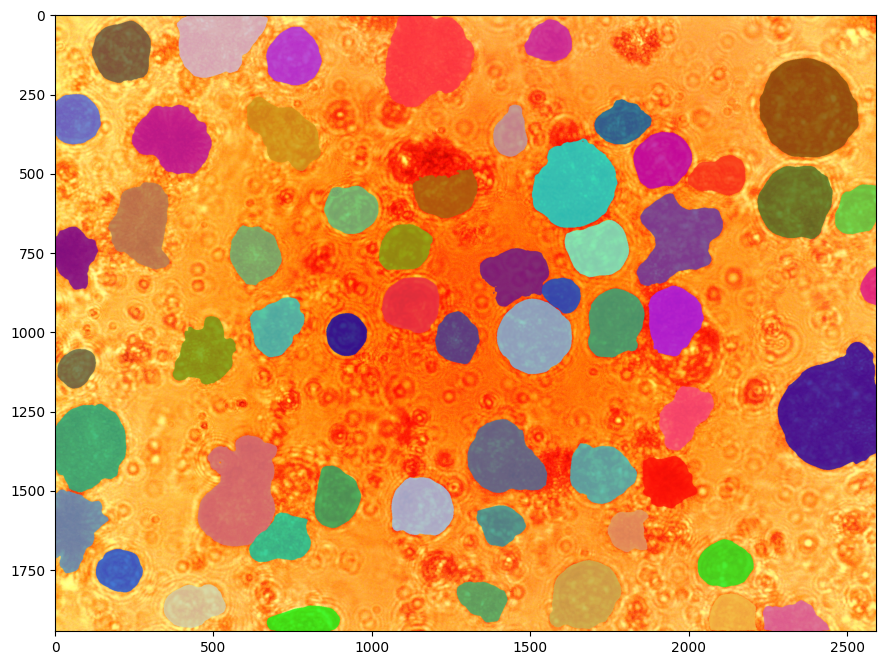

In [82]:
from utils.inference_sam import sam_inference_from_dino

# Detect all masks, scores and get the annotated frame
masks, scores, annotated_masks = sam_inference_from_dino(image_source, detected_boxes, 
                                                         model, processor, device)
# Plot the masks
plt.figure(figsize=(16,8))
plt.imshow(annotated_masks, cmap='gray')  


Transforms the masks that have been found in a numpy array.

In [83]:
# Transform masks to numpy array of shape [n_masks, width, height]
np_masks = (masks[0].numpy())[:,0,:,:]*1

## Patch dataset generation for the image

In this part of the pipeline we create the patches for the image. Later we select all the boxes and masks found for the original image and select just the ones that apply to every batch, and resize them to the resolution of the batch.

### 1. Create patches for the image

We want an exact size of the patches according to the size of the original image to avoid remainders.

In [84]:
# Desired patch size
patch_size = (324, 324, 3)

# Calculate the number of patches in each dimension
num_patches_h = H // patch_size[0]
num_patches_w = W // patch_size[1]

# Adjust the step size to ensure non-overlapping patches
step_size_h = H // num_patches_h
step_size_w = W // num_patches_w

# Create patches
patches = patchify(image_source, patch_size, step=(step_size_h, step_size_w, 1))

print(patches.shape)
print(num_patches_h, num_patches_w)
print(step_size_h, step_size_w)

(6, 8, 1, 324, 324, 3)
6 8
324 324


Therefore we get 6x8 patches.

This is an example of a patch.

(324, 324, 3)
<class 'numpy.ndarray'>


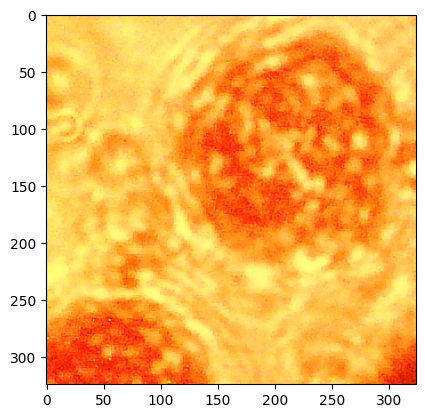

In [85]:
patch_test = patches[0,0,0,:,:]
print(patch_test.shape)
print(type(patch_test))
# Plot image
plt.imshow(patch_test, cmap='gray')  

Run a loop to get all patches with the corresponding boxes, masks and save the images.

1. **Find the coordinates of the patch in the original image**.
2. **Find boxes contained in the patch**.
    Given the boxes found earlier, we check if they are contained inside the patch, there can be 4 different cases:
    * The box is smaller than the patch and is contained inside the patch.
    * The box is partially contained inside the patch. Then we need to create a new box according to the size that is inside the patch.
    * The box is bigger than the patch and the patch is entirely contained in the box.
    * The box is not contained inside the patch.
3. **Find the masks and resize them**.
    Given the indices of the boxes found above we can get the masks of every patch and reshape them.
4. **Save the patch image, all masks for the patch and write information for the dataset**.
    Here we save the information for the dataset. Basically we save the patch in the image folder as an image, we save the masks for every patch and in the .json file we write the path to the patch image, the boxes and path to the masks.
5. **Save actual list to continue later**


![image](/home/ubuntu/notebooks/images/image_patch_box_crop.png)

In [86]:
# Save the new image in the folder
for r in range(num_patches_h):
    for c in range(num_patches_w):
        # 1. Find the coordinates of the patch in the original image
        # r and c are the indices of the patch (row, column)
        x_min = c*patch_size[0]
        x_max = (c + 1)*(patch_size[0]) - 1
        y_min = r*patch_size[1]
        y_max = (r + 1)*(patch_size[1]) - 1

        # 2. Find boxes contained in the patch
        patch_boxes = []
        final_patch_boxes = []
        patch_boxes_indices = []
        final_patch_masks = []
        for ind, box in enumerate(final_boxes.copy()):  # Use a copy to avoid modifying the original array
            # First case
            # 1
            if box[0] >= x_min and box[1] >= y_min and box[2] <= x_max and box[3] <= y_max:
                # Reshape box coordinates to patch size
                box_reshaped = box - [x_min, y_min, x_min, y_min]
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # Second case
            # 2
            # Only TL inside patch
            elif box[0] >= x_min and box[1] >= y_min and box[0] <= x_max and box[1] <= y_max and box[2] >= x_max and box[3] >= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = box_reshaped[0] - x_min
                box_reshaped[1] = box_reshaped[1] - y_min
                box_reshaped[2] = patch_size[0] - 1
                box_reshaped[3] = patch_size[1] - 1
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 3
            # Only BR inside patch
            elif box[0] <= x_min and box[1] <= y_min and box[2] >= x_min and box[3] >= y_min and box[2] <= x_max and box[3] <= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = 0
                box_reshaped[1] = 0
                box_reshaped[2] = box_reshaped[2] - x_min
                box_reshaped[3] = box_reshaped[3] - y_min
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 4
            # Only BL inside patch
            elif box[0] >= x_min and box[0] <= x_max and box[1] <= y_min and box[2] >= x_max and box[3] >= y_min and box[3] <= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = box_reshaped[0] - x_min
                box_reshaped[1] = 0
                box_reshaped[2] = patch_size[0] - 1
                box_reshaped[3] = box_reshaped[3] - y_min
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 5
            # Only TR inside patch
            elif box[0] <= x_min and box[1] >= y_min and box[1] <= y_max and box[2] >= x_min and box[2] <= x_max and box[3] >= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = 0
                box_reshaped[1] = box_reshaped[1] - y_min
                box_reshaped[2] = box_reshaped[2] - x_min
                box_reshaped[3] = patch_size[1] - 1
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 6
            # Only TR and BR inside patch
            elif box[0] <= x_min and box[1] >= y_min and box[1] <= y_max and box[2] >= x_min and box[2] <= x_max and box[3] >= y_min and box[3] <= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = 0
                box_reshaped[1] = box_reshaped[1] - y_min
                box_reshaped[2] = box_reshaped[2] - x_min
                box_reshaped[3] = box_reshaped[3] - y_min
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 7
            # Only BL and BR inside patch
            elif box[0] >= x_min and box[0] <= x_max and box[1] <= y_min and box[2] >= x_min and box[2] <= x_max and box[3] >= y_min and box[3] <= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = box_reshaped[0] - x_min
                box_reshaped[1] = 0
                box_reshaped[2] = box_reshaped[2] - x_min
                box_reshaped[3] = box_reshaped[3] - y_min
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 8
            # Only TL and BL inside patch
            elif box[0] >= x_min and box[0] <= x_max and box[1] >= y_min and box[1] <= y_max and box[2] >= x_max and box[3] >= y_min and box[3] <= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = box_reshaped[0] - x_min
                box_reshaped[1] = box_reshaped[1] - y_min
                box_reshaped[2] = patch_size[0] - 1
                box_reshaped[3] = box_reshaped[3] - y_min
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 9
            # Only TL and TR inside patch
            elif box[0] >= x_min and box[0] <= x_max and box[1] >= y_min and box[1] <= y_max and box[2] >= x_min and box[2] <= x_max and box[3] >= y_max:
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = box_reshaped[0] - x_min
                box_reshaped[1] = box_reshaped[1] - y_min
                box_reshaped[2] = box_reshaped[2] - x_min
                box_reshaped[3] = patch_size[1] - 1
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 10
            # Overlap on left but no vertices inside (TL and BL between the x_axis of patch)
            elif (box[0] <= x_min and box[1] <= y_min and box[2] >= x_min and box[2] <= x_max and box[3] >= y_max):
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = 0
                box_reshaped[1] = 0
                box_reshaped[2] = box_reshaped[2] - x_min
                box_reshaped[3] = patch_size[1] - 1
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 11
            # Overlap on right but no vertices inside (TR and BR between the x_axis of patch)
            elif (box[0] >= x_min and box[0] <= x_max and box[1] <= y_min and box[2] >= x_max and box[3] >= y_max):
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = box_reshaped[0] - x_min
                box_reshaped[1] = 0
                box_reshaped[2] = patch_size[0] - 1
                box_reshaped[3] = patch_size[1] - 1
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 12
            # Overlap on top but no vertices inside (BL and BR between the y_axis of patch)
            elif (box[0] <= x_min and box[1] <= y_min and box[2] >= x_max and box[3] >= y_min and box[3] <= y_max):
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = 0
                box_reshaped[1] = 0
                box_reshaped[2] = patch_size[0] - 1
                box_reshaped[3] = box_reshaped[3] - y_min
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 13
            # Overlap on bottom but no vertices inside (TL and TR between the y_axis of patch)
            elif (box[0] <= x_min and box[1] >= y_min and box[1] <= y_max and box[2] >= x_max and box[3] <= y_max):
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = 0
                box_reshaped[1] = box_reshaped[1] - y_min
                box_reshaped[2] = patch_size[0] - 1
                box_reshaped[3] = patch_size[1] - 1
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 14
            # Overlap horizontally but no vertices inside (box thinner and larger than patch)
            elif (box[0] <= x_min and box[1] >= y_min and box[1] <= y_max and box[2] >= x_max and box[3] <= y_max):
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = 0
                box_reshaped[1] = box_reshaped[1] - y_min
                box_reshaped[2] = patch_size[0] - 1
                box_reshaped[3] = box_reshaped[3] - y_min
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 15
            # Overlap vertically but no vertices inside (box thinner and larger than patch)
            elif (box[0] >= x_min and box[0] <= x_max and box[1] <= y_min and box[2] <= x_max and box[3] >= y_max):
                box_reshaped = box.copy()  # Use a copy to avoid modifying the original box
                box_reshaped[0] = box_reshaped[0] - x_min
                box_reshaped[1] = 0
                box_reshaped[2] = box_reshaped[2] - x_min
                box_reshaped[3] = patch_size[1] - 1
                patch_boxes.append(box_reshaped)
                patch_boxes_indices.append(ind)
            # 16
            # Third case
            elif box[0] <= x_min and box[1] <= y_min and box[2] >= x_max and box[3] >= y_max:
                patch_boxes.append(np.array([0., 0., patch_size[0] - 1, patch_size[1] - 1]))
                patch_boxes_indices.append(ind)
        patch_boxes = np.array(patch_boxes)

        # 3. Find the masks and resize them
        patch_masks = np_masks[patch_boxes_indices, y_min:y_max+1, x_min:x_max+1]

        # 4. Keep only the masks that are not empty
        count = 0
        for i, mask in enumerate(patch_masks):
            if np.max(mask) != 0 and np.min(mask) != 1:
                # Save the box of the mask
                final_patch_boxes.append(patch_boxes[i])
                # Save the mask as an image
                cv2.imwrite(os.path.join(data_dir, "private", mask_img_path, img_name + "_" + str(r) + str(c) + "_" + str(count) + ".png"), mask * 255)
                # Save the mask location 
                final_patch_masks.append(os.path.join(mask_img_path, img_name + "_" + str(r) + str(c) + "_" + str(count) + ".png")) 
                # Update count
                count += 1

        final_patch_boxes = np.array(final_patch_boxes)
                
        # 4. Save patch image and write information for the dataset
        # Add the patch name
        patch_name = os.path.join(fold_img_path, img_name + "_" + str(r) + str(c) + ".png")
        # Save image
        (Image.fromarray(patches[r,c,0,:,:])).save(os.path.join(data_dir, "private", patch_name))        

        # Save image information in arrays
        img_source_list.append(patch_name)
        boxes_list.append(final_patch_boxes)
        masks_list.append(final_patch_masks)

        print("Patch: (", r, ",", c, "). Number of boxes found:", final_patch_boxes.shape[0])

Patch: ( 0 , 0 ). Number of boxes found: 3
Patch: ( 0 , 1 ). Number of boxes found: 3
Patch: ( 0 , 2 ). Number of boxes found: 3
Patch: ( 0 , 3 ). Number of boxes found: 1
Patch: ( 0 , 4 ). Number of boxes found: 3
Patch: ( 0 , 5 ). Number of boxes found: 2
Patch: ( 0 , 6 ). Number of boxes found: 1
Patch: ( 0 , 7 ). Number of boxes found: 1
Patch: ( 1 , 0 ). Number of boxes found: 3
Patch: ( 1 , 1 ). Number of boxes found: 3
Patch: ( 1 , 2 ). Number of boxes found: 2
Patch: ( 1 , 3 ). Number of boxes found: 2
Patch: ( 1 , 4 ). Number of boxes found: 3
Patch: ( 1 , 5 ). Number of boxes found: 5
Patch: ( 1 , 6 ). Number of boxes found: 5
Patch: ( 1 , 7 ). Number of boxes found: 3
Patch: ( 2 , 0 ). Number of boxes found: 2
Patch: ( 2 , 1 ). Number of boxes found: 4
Patch: ( 2 , 2 ). Number of boxes found: 4
Patch: ( 2 , 3 ). Number of boxes found: 4
Patch: ( 2 , 4 ). Number of boxes found: 6
Patch: ( 2 , 5 ). Number of boxes found: 7
Patch: ( 2 , 6 ). Number of boxes found: 3
Patch: ( 2 

In [87]:
print(len(img_source_list))

144


This is the end to generate patches for an image and get all the corresponding boxes and masks. Go back to the beginning to load a new image and generate batches.

## FINAL: Dataset creation

Now we can create the file needed to later load the information as a dataset. To do it, we create a pandas dataframe that we save later as .json format. 

In [88]:
df = pd.DataFrame(list(zip(img_source_list, boxes_list, masks_list)),
               columns =['img', 'boxes', 'masks'])

df.to_json(data_dir + "/metadata.json", orient = "records", lines = True)

del(df)

This .json file can be load later to continue with the dataset creation. 